In [1]:
import pandas as pd 
import numpy as np
#plots
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#matrix
from scipy.sparse import csr_matrix

In [2]:
df_users=pd.read_csv('steam_users.csv')

In [3]:
df_users.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


The first row of the dataset is the titles of the columns in our dataframe.

We will put new titles for the columns.

In [4]:
df_users.rename(columns = {'151603712' : 'User_id', 'The Elder Scrolls V Skyrim' : 'Game', 'purchase' : 'Action', '1' : 'Hours-played', '0' : 'Last_column'}, inplace = True)

In [5]:
df_users.head()

,User_id,Game,Action,Hours-played,Last_column
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


We will add the first row that we lost from the dataset.

In [6]:
first_row = []
first_row.insert(0, {'User_id':'151603712', 'Game':'The Elder Scrolls V Skyrim', 'Action':'purchase', 'Hours-played': '1', 'Last_column':'0'})
df_users = pd.concat([pd.DataFrame(first_row), df_users], ignore_index = True)
df_users.head(10)

,User_id,Game,Action,Hours-played,Last_column
0,151603712,The Elder Scrolls V Skyrim,purchase,1,0
1,151603712,The Elder Scrolls V Skyrim,play,273,0
2,151603712,Fallout 4,purchase,1,0
3,151603712,Fallout 4,play,87,0
4,151603712,Spore,purchase,1,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [7]:
print("The dataset has", df_users.shape[0],"observations.")

The dataset has 200000 observations.


### Action

In [8]:
actions = df_users["Action"].value_counts()
print(actions)

purchase    129511
play         70489
Name: Action, dtype: int64


In [9]:
one_purchase = 0
more_purchases = 0
for i in range(df_users.shape[0]):
    if df_users.iloc[i]["Action"] == "purchase" and df_users.iloc[i]["Hours-played"] != 1:
        more_purchases +=1
    elif df_users.iloc[i]["Action"] == "purchase" and df_users.iloc[i]["Hours-played"] == 1:
        one_purchase += 1
print("Number of only one purchases:",one_purchase,"/",actions[0])
print("Number of more than one purchases:",more_purchases,"/",actions[0])

Number of only one purchases: 129510 / 129511
Number of more than one purchases: 1 / 129511


We will drop all the rows with purchase in the actions because this information is useless. If a user plays the game, then he had already bouhgt it. Also if a user has bought a game and hasn't played with it, then he is not interested for the game.

In [10]:
delete_rows = []
for i in range(df_users.shape[0]):
    if df_users.iloc[i]['Action'] == 'purchase':
        delete_rows.append(i)
df_users = df_users.drop(labels=delete_rows, axis=0)

In [11]:
df_users.head(10)

,User_id,Game,Action,Hours-played,Last_column
1,151603712,The Elder Scrolls V Skyrim,play,273,0
3,151603712,Fallout 4,play,87,0
5,151603712,Spore,play,14.9,0
7,151603712,Fallout New Vegas,play,12.1,0
9,151603712,Left 4 Dead 2,play,8.9,0
11,151603712,HuniePop,play,8.5,0
13,151603712,Path of Exile,play,8.1,0
15,151603712,Poly Bridge,play,7.5,0
17,151603712,Left 4 Dead,play,3.3,0
19,151603712,Team Fortress 2,play,2.8,0


Now, the column 'Action' has only one value (play), so it cannot give us any other information and we will drop it.

In [12]:
df_users = df_users.drop(['Action'], axis=1)

In [13]:
print("Now the dataset has", df_users.shape[0],"observations.")

Now the dataset has 70489 observations.


In [14]:
new_index = [ i for i in range(df_users.shape[0])]
df_users.index = new_index
df_users.head()

,User_id,Game,Hours-played,Last_column
0,151603712,The Elder Scrolls V Skyrim,273,0
1,151603712,Fallout 4,87,0
2,151603712,Spore,14.9,0
3,151603712,Fallout New Vegas,12.1,0
4,151603712,Left 4 Dead 2,8.9,0


Now, we will add an extra column, where we will match each game with its appid from the dataset "game_details".

In [15]:
df_details=pd.read_csv('games_details_dataset.csv')

In [16]:
not_match = []
game_id = {}
game_genre = {}
game_category = {}
game_playtime = {}
game_positive_votes = {}
games = df_users["Game"].value_counts()
for game in games.keys():
    if list(df_details["name"]).count(game)>0:
        game_id[game] = df_details.iloc[list(df_details["name"]).index(game)]["appid"]
        game_genre[game] = df_details.iloc[list(df_details["name"]).index(game)]["genre_new"]
        game_category[game] = df_details.iloc[list(df_details["name"]).index(game)]["cat_new"]
        game_playtime[game] = df_details.iloc[list(df_details["name"]).index(game)]["playtime"]
        game_positive_votes[game] = df_details.iloc[list(df_details["name"]).index(game)]["rating_sign"]
    else:
        not_match.append(game)

In [17]:
print("Games with matched ids:", len(game_id),"/",len(games))

Games with matched ids: 2362 / 3592


In [18]:
print("Games with NO matched ids:", len(not_match),"/",len(games))

Games with NO matched ids: 1230 / 3592


We remove unmatched games.

In [19]:
not_match_index = []
for i in range(df_users.shape[0]):
    if not_match.count(df_users.iloc[i]["Game"])>0:
        not_match_index.append(i)
df_users = df_users.drop(labels=not_match_index, axis=0)

In [20]:
game_to_id = []
game_to_genre = []
game_to_category = []
game_to_playtime = []
game_to_positive_votes = []
for i in range(df_users.shape[0]):
    if list(game_id.keys()).count(df_users.iloc[i]["Game"])>0:
        game_to_id.append(game_id[df_users.iloc[i]["Game"]])
        game_to_genre.append(game_genre[df_users.iloc[i]["Game"]])
        game_to_category.append(game_category[df_users.iloc[i]["Game"]])
        game_to_playtime.append(game_playtime[df_users.iloc[i]["Game"]])
        game_to_positive_votes.append(game_positive_votes[df_users.iloc[i]["Game"]])
    else:
        game_to_id.append(0)

In [21]:
df_users["Game_id"] = game_to_id
df_users["Game_genre"] = game_to_genre
df_users["Game_category"] = game_to_category
df_users["Game_playtime"] = game_to_playtime
df_users["Game_positive_votes"] = game_to_positive_votes

In [22]:
df_users.head(10)

,User_id,Game,Hours-played,Last_column,Game_id,Game_genre,Game_category,Game_playtime,Game_positive_votes
0,151603712,The Elder Scrolls V Skyrim,273,0,72850,violent,no_multiplayer,more,positive
1,151603712,Fallout 4,87,0,377160,violent,no_multiplayer,more,positive
3,151603712,Fallout New Vegas,12.1,0,22380,violent,multiplayer,more,positive
4,151603712,Left 4 Dead 2,8.9,0,550,action,multiplayer,more,positive
5,151603712,HuniePop,8.5,0,339800,violent,no_multiplayer,more,positive
6,151603712,Path of Exile,8.1,0,238960,violent,multiplayer,more,positive
7,151603712,Poly Bridge,7.5,0,367450,action,multiplayer,more,positive
8,151603712,Left 4 Dead,3.3,0,500,action,multiplayer,more,positive
9,151603712,Team Fortress 2,2.8,0,440,action,multiplayer,more,positive
11,151603712,The Banner Saga,2,0,237990,violent,no_multiplayer,more,positive


In [23]:
df_users.shape[0]

52770

In [24]:
genre = df_users["Game_genre"].value_counts()
print(genre)

action           36821
violent          10867
casual            3382
sports_racing     1139
other              561
Name: Game_genre, dtype: int64


In [25]:
category = df_users["Game_category"].value_counts()
print(category)

multiplayer       40749
no_multiplayer    12021
Name: Game_category, dtype: int64


In [26]:
playtime = df_users["Game_playtime"].value_counts()
print(playtime)

more    47124
less     5646
Name: Game_playtime, dtype: int64


In [27]:
pos = df_users["Game_positive_votes"].value_counts()
print(pos)

positive    52008
negative      762
Name: Game_positive_votes, dtype: int64


### Last column

In [28]:
last = df_users["Last_column"].value_counts()
print(last)

0    52770
Name: Last_column, dtype: int64


The last column has the zero value in all observations, so it doesn't give us any information. We will drop this column too.

In [29]:
df_users = df_users.drop(['Last_column'], axis=1)

In [30]:
df_users.head()

,User_id,Game,Hours-played,Game_id,Game_genre,Game_category,Game_playtime,Game_positive_votes
0,151603712,The Elder Scrolls V Skyrim,273,72850,violent,no_multiplayer,more,positive
1,151603712,Fallout 4,87,377160,violent,no_multiplayer,more,positive
3,151603712,Fallout New Vegas,12.1,22380,violent,multiplayer,more,positive
4,151603712,Left 4 Dead 2,8.9,550,action,multiplayer,more,positive
5,151603712,HuniePop,8.5,339800,violent,no_multiplayer,more,positive


### Hours played

In [31]:
hours = df_users["Hours-played"].value_counts()
print(hours)

0.2       2124
0.3       1785
0.4       1584
0.5       1291
0.1       1239
          ... 
1107.0       1
1102.0       1
1097.0       1
1095.0       1
828.0        1
Name: Hours-played, Length: 1525, dtype: int64


In [32]:
less_than_hour = 0
more_than_hour = 0
for i in range(df_users.shape[0]):
    if df_users.iloc[i]["Hours-played"] < 2:
        less_than_hour +=1
    else:
        more_than_hour += 1
print("Number of less than hour:",less_than_hour,"/",df_users.shape[0])
print("Number of more than hour:",more_than_hour,"/",df_users.shape[0])

Number of less than hour: 18053 / 52770
Number of more than hour: 34717 / 52770


We match the hours played with a rating score (1-5).

In [33]:
rate_list = []
for i in range(df_users.shape[0]):
    if df_users.iloc[i]["Hours-played"] >= 100:
        rate_list.append(5)
    elif df_users.iloc[i]["Hours-played"] < 100 and df_users.iloc[i]["Hours-played"] >= 50:
        rate_list.append(4)
    elif df_users.iloc[i]["Hours-played"] < 50 and df_users.iloc[i]["Hours-played"] >= 10:
        rate_list.append(3)
    elif df_users.iloc[i]["Hours-played"] < 10 and df_users.iloc[i]["Hours-played"] >= 2:
        rate_list.append(2)
    else:
        rate_list.append(1)
df_users["rating"] = rate_list

In [34]:
rate = df_users["rating"].value_counts()
print(rate)

1    18053
2    15025
3    11900
5     4803
4     2989
Name: rating, dtype: int64


### Users

We have to clean the dataset from duplicates.

In [35]:
df_users.User_id = df_users.User_id.astype('int')
df_users = df_users.drop_duplicates(['User_id', 'Game'], keep = 'last')

In [36]:
users = df_users["User_id"].value_counts()
print("Number of users in the dataset:",len(users))

Number of users in the dataset: 10520


In [37]:
print(users)

62990992     347
138941587    225
11403772     219
47457723     206
49893565     199
            ... 
133547462      1
166295260      1
29730534       1
207406826      1
203370502      1
Name: User_id, Length: 10520, dtype: int64


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Users')]

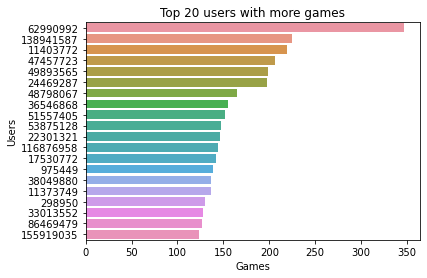

In [38]:
plt.title('Top 20 users with more games')
ax = sns.countplot(y="User_id", data=df_users,order=df_users.User_id.value_counts().iloc[:20].index)
ax.set(xlabel="Games", ylabel = "Users")

### Games

In [39]:
games = df_users["Game"].value_counts()
print("Number of games in the dataset:",len(games))

Number of games in the dataset: 2362


In [40]:
print(games)

Dota 2                             4841
Team Fortress 2                    2323
Counter-Strike Global Offensive    1377
Unturned                           1069
Left 4 Dead 2                       801
                                   ... 
AR-K                                  1
Heroes of a Broken Land               1
Panzer Tactics HD                     1
Critical Mass                         1
The Chaos Engine                      1
Name: Game, Length: 2362, dtype: int64


[Text(0.5, 0, 'Users'), Text(0, 0.5, 'Games')]

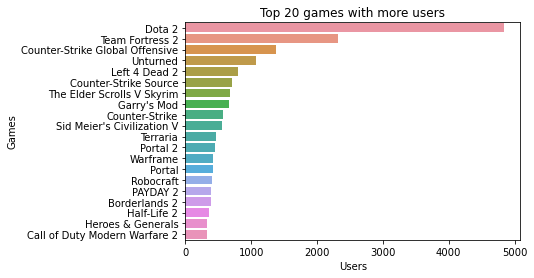

In [41]:
plt.title('Top 20 games with more users')
ax = sns.countplot(y="Game", data=df_users,order=df_users.Game.value_counts().iloc[:20].index)
ax.set(xlabel="Users", ylabel = "Games")

In [42]:
new_index = [ i for i in range(df_users.shape[0])]
df_users.index = new_index
df_users.head(10)

,User_id,Game,Hours-played,Game_id,Game_genre,Game_category,Game_playtime,Game_positive_votes,rating
0,151603712,The Elder Scrolls V Skyrim,273,72850,violent,no_multiplayer,more,positive,5
1,151603712,Fallout 4,87,377160,violent,no_multiplayer,more,positive,4
2,151603712,Fallout New Vegas,12.1,22380,violent,multiplayer,more,positive,3
3,151603712,Left 4 Dead 2,8.9,550,action,multiplayer,more,positive,2
4,151603712,HuniePop,8.5,339800,violent,no_multiplayer,more,positive,2
5,151603712,Path of Exile,8.1,238960,violent,multiplayer,more,positive,2
6,151603712,Poly Bridge,7.5,367450,action,multiplayer,more,positive,2
7,151603712,Left 4 Dead,3.3,500,action,multiplayer,more,positive,2
8,151603712,Team Fortress 2,2.8,440,action,multiplayer,more,positive,2
9,151603712,The Banner Saga,2,237990,violent,no_multiplayer,more,positive,2


In [43]:
df_users.head()

,User_id,Game,Hours-played,Game_id,Game_genre,Game_category,Game_playtime,Game_positive_votes,rating
0,151603712,The Elder Scrolls V Skyrim,273,72850,violent,no_multiplayer,more,positive,5
1,151603712,Fallout 4,87,377160,violent,no_multiplayer,more,positive,4
2,151603712,Fallout New Vegas,12.1,22380,violent,multiplayer,more,positive,3
3,151603712,Left 4 Dead 2,8.9,550,action,multiplayer,more,positive,2
4,151603712,HuniePop,8.5,339800,violent,no_multiplayer,more,positive,2


In [44]:
df_users.to_csv('Users_games_dataset.csv', index=False)